# Fake News Detection

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Data Preprocessing

In [2]:
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')

In [3]:
df_fake.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [4]:
df_true.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


In [5]:
df_fake.shape,df_true.shape

((23481, 4), (21417, 4))

In [6]:
# Inserting a column "class" as target feature

df_fake["class"] = 0
df_true["class"] = 1

In [7]:
# Merging true and fake DataFrames

df = pd.concat([df_fake,df_true],axis = 0)
df.head(5)

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [8]:
# checking Null values 

df.isnull().sum()

title      0
text       0
subject    0
date       0
class      0
dtype: int64

In [9]:
# shuffling the data

df = df.sample(frac =1)

In [10]:
df.reset_index(inplace = True)
df.drop(['index'],axis=1,inplace= True)

In [11]:
df.columns

Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')

In [12]:
df = df.drop(['title', 'subject', 'date'], axis=1)

In [13]:
df.head()

,text,class
0,An Obama foot soldier in his divisive war on A...,0
1,NEW YORK (Reuters) - Lawyers for Republican pr...,1
2,"In January, GOP presidential candidate Donald ...",0
3,"Yes, we did say she s a Harvard Business Schoo...",0
4,BRUSSELS (Reuters) - Polish reforms of its jud...,1


<AxesSubplot:xlabel='class', ylabel='count'>

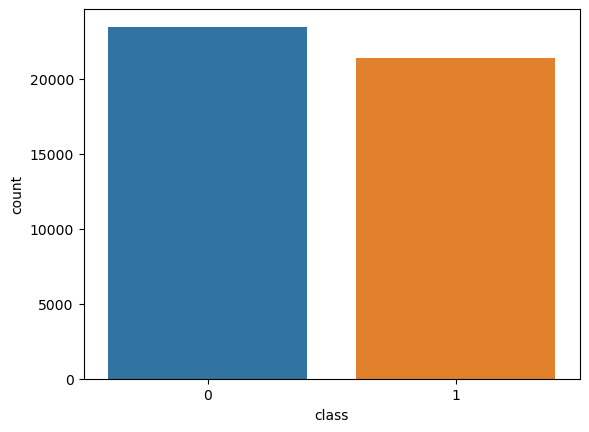

In [14]:
sns.countplot(data = df , x = 'class',order = df['class'].value_counts().index)

In [15]:
# Create a function to process the text

def remove_punctuations(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub('', '', text)
    text = re.sub("\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

    return text

In [16]:
df['text'] = df['text'].apply(remove_punctuations)

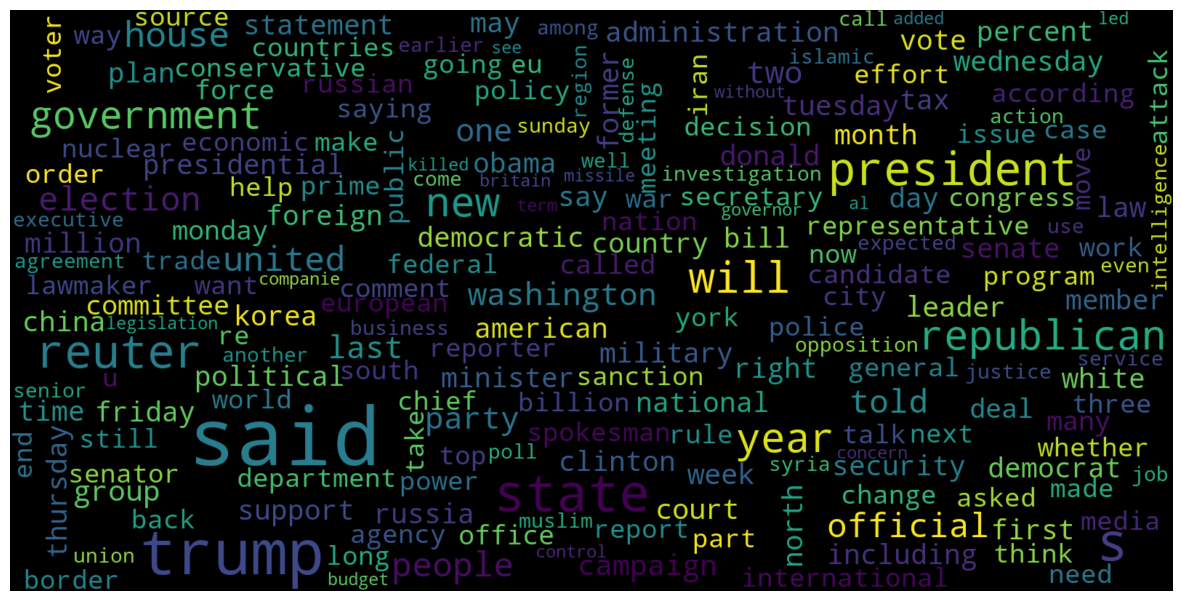

In [17]:
# word cloud for True news

consolidated = ' '.join(
    word for word in df['text'][df['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

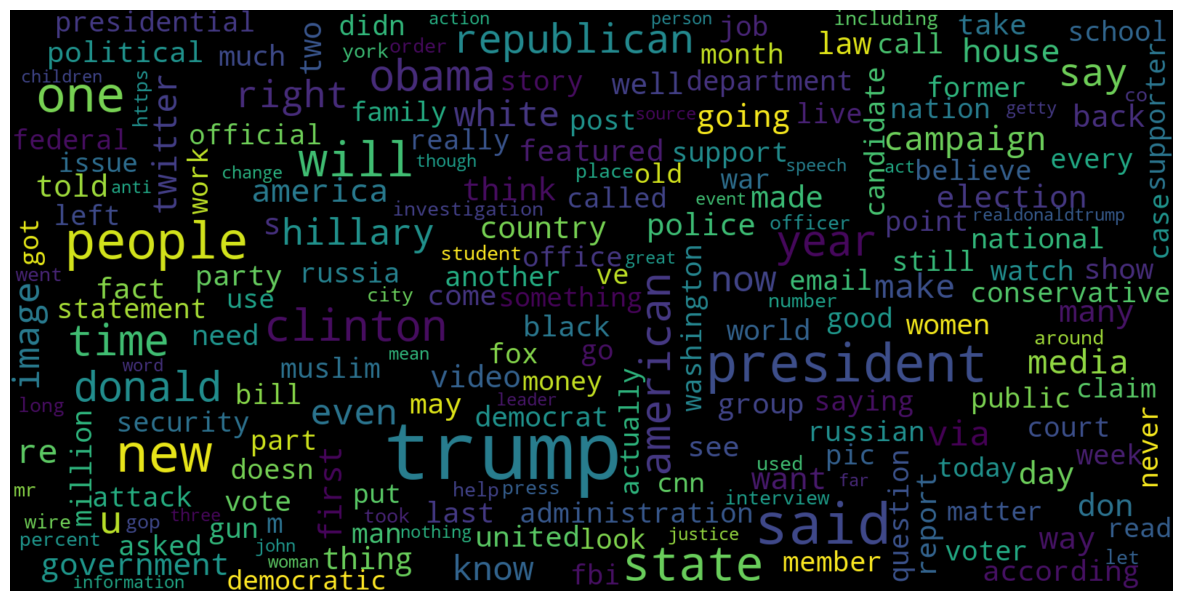

In [18]:
# word cloud for Fake News

consolidated = ' '.join(
    word for word in df['text'][df['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
# Defining independent and dependent Variables

In [20]:
x = df['text']
y = df['class']

In [21]:
# splitting Training and Testing data

In [22]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.25,random_state=100)

# Converting text into vectors

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(xtrain)
x_test = vectorization.transform(xtest)   

# Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train,ytrain)
y_pred = lr.predict(x_test)
print(accuracy_score(y_pred,ytest))
print(classification_report(y_pred,ytest))

0.987706013363029
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5848
           1       0.99      0.98      0.99      5377

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



# DecisionTree Classification

In [25]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train,ytrain)
y_pred = dt.predict(x_test)
print(accuracy_score(y_pred,ytest))
print(classification_report(y_pred,ytest))

0.9956347438752784
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5891
           1       0.99      1.00      1.00      5334

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



# Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train,ytrain)
y_pred = rfc.predict(x_test)
print(accuracy_score(y_pred,ytest))
print(classification_report(y_pred,ytest))

0.9902004454342984
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5888
           1       0.99      0.99      0.99      5337

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [27]:
cm = confusion_matrix(ytest,y_pred)
cm

array([[5831,   53],
       [  57, 5284]], dtype=int64)

Text(50.722222222222214, 0.5, 'Actual')

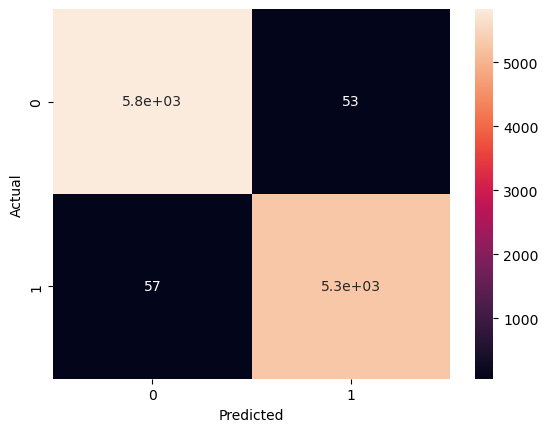

In [28]:
cm = confusion_matrix(ytest,y_pred)
sns.heatmap(cm,annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')